In [1]:
import ROOT
from itertools import combinations, combinations_with_replacement, product

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x7e8f190


In [2]:
%jsroot on

In [3]:
# ROOT.EnableImplicitMT(4)
ROOT.TH1.SetDefaultSumw2()

In [4]:
ROOT.gInterpreter.Declare("#include \"WWTools.h\"")
ROOT.gSystem.Load("OO/diehl/libObservable.so")
ROOT.gInterpreter.Declare("#include \"OO/diehl/OOTools.h\"")

True

In [5]:
%%cpp
using namespace ROOT::VecOps;

In [6]:
# file = ROOT.TFile("data/post_paris/nano/test.root")
file = ROOT.TFile("data/post_paris/nano/all.root")
tree = file["events"]
# tree.AddFriend("events", "data/paris/nano/test_params_flat.root")
tree.AddFriend("events", "data/paris/nano/all_params_flat.root")

df = ROOT.RDataFrame(tree)

n_bins = 10
x_angle = 0.014 # rad

# TODO implement
beamPol1 = 0.
beamPol2 = 0.
lumi = 1000. # inverse fb

# use same masses as in whizard!
mW = 80.419
mZ = 91.1882
ROOT.OOTools.init(250, mW, mZ)

In [7]:
df.Describe()

Dataframe from TTree events in file data/post_paris/nano/all.root
with friend
  events data/paris/nano/all_params_flat.root

Property                Value
--------                -----
Columns in total           89
Columns from defines        0
Event loops run             0
Processing slots            1

Column                                          Type                                                            Origin
------                                          ----                                                            ------
e_charge                                        Float_t                                                         Dataset
e_lvec                                          ROOT::Math::LorentzVector<ROOT::Math::PxPyPzE4D<double> >       Dataset
e_lvec.fCoordinates                             ROOT::Math::PxPyPzE4D<double>                                   Dataset
e_lvec.fCoordinates.fT                          Double_t                                        

In [8]:
# do weight calculations: for now only unpolarized
# should happen before any cuts
total_events = tree.GetEntries()

df = df.Define("pol_weight", "1./4.")
# df = df.Define("lumi_weight", "1")
df = df.Define("lumi_weight", f"{lumi} * params_crossSection / {total_events}.")
df = df.Define("weight", "pol_weight * lumi_weight")

In [9]:
df = df.Define("sqrt_s_E", "params_Energy")
# XXX: ignoring the electron mass here
df = df.Define("sqrt_s_lvec", f"ROOT::Math::PxPyPzEVector(sqrt_s_E * sin({x_angle}/2.), 0, 0, sqrt_s_E)")

# TODO correct electron mass back to m_e, maybe as a variation
# df = df.Redefine("e_lvec", "vec = PxPyPzEVector(e_lvec), vec.SetE")

# FIXME debug

# re-build hadronic lvecs from component vectors!
df = df.Define("had_lvecs", "Construct<ROOT::Math::PxPyPzEVector>(had_lvecs_px, had_lvecs_py, had_lvecs_pz, had_lvecs_e)")
df = df.Define("had_sum_lvec", "Sum(had_lvecs, ROOT::Math::PxPyPzEVector())")
df = df.Define("had_lvecs_size", "had_lvecs.size()")

df = df.Define("had_mc_acc_lvecs", "Construct<ROOT::Math::PxPyPzEVector>(had_mc_acc_lvecs_px, had_mc_acc_lvecs_py, had_mc_acc_lvecs_pz, had_mc_acc_lvecs_e)")
df = df.Define(f"had_mc_acc_sum_lvec", f"Sum(had_mc_acc_lvecs, ROOT::Math::PxPyPzEVector())")
# TODO rework, mark stuff as overlay etc, can still not mark stuff as overlay as I get one lvec per jet now, not one per particle :(

df = df.Define("visible_lvec", "e_lvec + isr1_lvec + isr2_lvec + ovl_lvec + had_sum_lvec")
df = df.Define("visible_mc_lvec", "e_mc_sum_lvec + isr1_mc_sum_lvec + isr2_mc_sum_lvec + ovl_mc_sum_lvec + had_mc_acc_sum_lvec")
# TODO: add 3 variations: no removal, naive removal (Andre), cheated removal
# Andre's cut: log_10 Pt > 0.2 sin theta + something
df = df.Define("identified_ovl_lvec", "ROOT::Math::PxPyPzEVector()")
# TODO variations: none, fitted/reconstructed, cheated ISR goes here
df = df.Define("identified_isr_lvec", "ROOT::Math::PxPyPzEVector()")

In [10]:
df = df.Vary("identified_ovl_lvec", "RVec<ROOT::Math::PxPyPzEVector>({ovl_lvec})", ["cheated"], "ovl")
df = df.Vary("identified_isr_lvec", "RVec<ROOT::Math::PxPyPzEVector>({isr1_lvec + isr2_lvec})", ["cheated"], "isr")

In [11]:

df = df.Define("visible_corrected_lvec", "visible_lvec - identified_ovl_lvec - identified_isr_lvec")
df = df.Define("missing_E_lvec", "sqrt_s_lvec - visible_corrected_lvec")
df = df.Define("reco_nu_lvec", "missing_E_lvec")
# TODO: correct nu mass back to 0?
df = df.Define("reco_nu_mc_lvec", "nu_mc_sum_lvec")

df = df.Define("W_lep_lvec", "e_lvec + reco_nu_lvec")
df = df.Define("W_had_lvec", "visible_corrected_lvec - e_lvec")

df = df.Define("W_lep_mc_lvec", "e_mc_sum_lvec + nu_mc_sum_lvec")
# TODO maybe vary MC?
# df = df.Define("W_had_mc_lvec", "visible_corrected_lvec - e_lvec")
df = df.Define("W_had_mc_lvec", "had_mc_acc_sum_lvec")

In [12]:
df = df.Define("W_lep_invM", "W_lep_lvec.mass()")
df = df.Define("W_had_invM", "W_had_lvec.mass()")

df = df.Define("W_lep_mc_invM", "W_lep_mc_lvec.mass()")
df = df.Define("W_had_mc_invM", "W_had_mc_lvec.mass()")

In [13]:

df = df.Define("e_minus_vec", f"ROOT::Math::XYZVector(sin({x_angle}/2.), 0, cos({x_angle}/2.))")

df = df.Define("CosTheta_W_lep", "ROOT::Math::VectorUtil::CosTheta(W_lep_lvec, e_minus_vec)")
df = df.Define("CosTheta_W_had", "ROOT::Math::VectorUtil::CosTheta(W_had_lvec, e_minus_vec)")

# FIXME: pass e_minus_vec?? or unboost everything in advance!
df = df.Define("l_star_lvec", "WWTools::starVector(W_lep_lvec, e_lvec)")

df = df.Define("l_theta_star", "l_star_lvec.Theta()")
df = df.Define("l_phi_star", "l_star_lvec.Phi()")
df = df.Define("l_cosTheta_star", "cos(l_theta_star)")

# mc
df = df.Define("CosTheta_W_lep_mc", "ROOT::Math::VectorUtil::CosTheta(W_lep_mc_lvec, e_minus_vec)")
df = df.Define("CosTheta_W_had_mc", "ROOT::Math::VectorUtil::CosTheta(W_had_mc_lvec, e_minus_vec)")

# FIXME: pass e_minus_vec??
df = df.Define("l_star_mc_lvec", "WWTools::starVector(W_lep_mc_lvec, e_mc_sum_lvec)")

df = df.Define("l_theta_star_mc", "l_star_mc_lvec.Theta()")
df = df.Define("l_phi_star_mc", "l_star_mc_lvec.Phi()")
df = df.Define("l_cosTheta_star_mc", "cos(l_theta_star_mc)")

# JETS

df = df.Define("jet1", "had_lvecs[0]")
# FIXME: choice can probably be improved...
df = df.Define("jet2", "had_lvecs[1]")

df = df.Define("jet1_star_lvec", "WWTools::starVector(W_had_lvec, jet1)")
df = df.Define("jet1_theta_star", "jet1_star_lvec.Theta()")
df = df.Define("jet1_phi_star", "jet1_star_lvec.Phi()")
df = df.Define("jet1_cosTheta_star", "cos(jet1_theta_star)")

df = df.Define("jet2_star_lvec", "WWTools::starVector(W_had_lvec, jet2)")
df = df.Define("jet2_theta_star", "jet2_star_lvec.Theta()")
df = df.Define("jet2_phi_star", "jet2_star_lvec.Phi()")
df = df.Define("jet2_cosTheta_star", "cos(jet2_theta_star)")

# MC JETS
df = df.Define("jet1_mc", "had_mc_acc_lvecs[0]")
# FIXME: choice can probably be improved...
df = df.Define("jet2_mc", "had_mc_acc_lvecs[1]")

df = df.Define("jet1_mc_star_lvec", "WWTools::starVector(W_had_mc_lvec, jet1_mc)")
df = df.Define("jet1_mc_theta_star", "jet1_mc_star_lvec.Theta()")
df = df.Define("jet1_mc_phi_star", "jet1_mc_star_lvec.Phi()")
df = df.Define("jet1_mc_cosTheta_star", "cos(jet1_mc_theta_star)")

df = df.Define("jet2_mc_star_lvec", "WWTools::starVector(W_had_mc_lvec, jet2_mc)")
df = df.Define("jet2_mc_theta_star", "jet2_mc_star_lvec.Theta()")
df = df.Define("jet2_mc_phi_star", "jet2_mc_star_lvec.Phi()")
df = df.Define("jet2_mc_cosTheta_star", "cos(jet2_mc_theta_star)")

In [14]:
# residuals

df = df.Define("delta_CosTheta_W_had", "(CosTheta_W_had - CosTheta_W_had_mc)")
df = df.Define("delta_l_phi_star", "(l_phi_star - l_phi_star_mc)")
df = df.Define("delta_l_cosTheta_star", "(l_cosTheta_star - l_cosTheta_star_mc)")

In [15]:
df = df.Define("dg1z_jet1", "OOTools::O_dg1z(CosTheta_W_lep, l_cosTheta_star, jet1_cosTheta_star, l_phi_star, jet1_phi_star)")
df = df.Define("dkg_jet1", "OOTools::O_dkg(CosTheta_W_lep, l_cosTheta_star, jet1_cosTheta_star, l_phi_star, jet1_phi_star)")
df = df.Define("lz_jet1", "OOTools::O_lz(CosTheta_W_lep, l_cosTheta_star, jet1_cosTheta_star, l_phi_star, jet1_phi_star)")

# MC

df = df.Define("dg1z_jet1_mc", "OOTools::O_dg1z(CosTheta_W_lep_mc, l_cosTheta_star_mc, jet1_mc_cosTheta_star, l_phi_star_mc, jet1_mc_phi_star)")
df = df.Define("dkg_jet1_mc", "OOTools::O_dkg(CosTheta_W_lep_mc, l_cosTheta_star_mc, jet1_mc_cosTheta_star, l_phi_star_mc, jet1_mc_phi_star)")
df = df.Define("lz_jet1_mc", "OOTools::O_lz(CosTheta_W_lep_mc, l_cosTheta_star_mc, jet1_mc_cosTheta_star, l_phi_star_mc, jet1_mc_phi_star)")

OOs = ["dg1z", "dkg", "lz"]
for oo in OOs:
    df = df.Alias(f"O_{oo}", f"{oo}_jet1")
    df = df.Alias(f"O_{oo}_mc", f"{oo}_jet1_mc")

for oo_1, oo_2 in combinations_with_replacement(OOs, 2):
    df = df.Define(f"O_{oo_1}O_{oo_2}", f"O_{oo_1} * O_{oo_2}")
    df = df.Define(f"O_{oo_1}O_{oo_2}_mc", f"O_{oo_1}_mc * O_{oo_2}_mc")

In [16]:
# Filters go here:
# df = df.Filter("events.params_WWCategorisation_TrueCat == 2")
# df = df.Filter("events.params_WWCategorisation_RecoCat == 2")
# df = df.Filter("params_WWCategorisation_RecoCatAdvanced == 2")

cut = 5.0
df = df.Filter(f"abs(W_lep_invM - {mW}) < {cut}")
df = df.Filter(f"abs(W_had_invM - {mW}) < {cut}")
df = df.Filter(f"abs(W_lep_mc_invM - {mW}) < {cut}")
df = df.Filter(f"abs(W_had_mc_invM - {mW}) < {cut}")
plots = "plots/post_paris/draft/W_5_GeV_cut"
# TODO: update text
cut_text = f"abs(M_{{e#nu}} - {mW}) < {cut}"
df = df.Filter("had_lvecs_size == 2")
df = df.Filter("e_charge < 0") # FIXME: need to change the OO functions otherwise iiuc
# plots = "plots/post_paris/draft/no_cut"
# cut_text = "no cut"

In [17]:
oo_bins = 100
oo_start = -1.
oo_end = 1.

h_dg1z_jet1 = df.Histo1D(("", ";O_{#delta g_{1}^{Z}}", oo_bins, oo_start, oo_end), "dg1z_jet1", "weight")
h_dkg_jet1 = df.Histo1D(("", ";O_{#delta#kappa_{#gamma}}", oo_bins, oo_start, oo_end), "dkg_jet1", "weight")
h_lz_jet1 = df.Histo1D(("", ";O_{#lambda_{Z}}", oo_bins, oo_start, oo_end), "lz_jet1", "weight")

h_dg1z_jet1_mc = df.Histo1D(("", ";#delta g_{1}^{Z}", oo_bins, oo_start, oo_end), "dg1z_jet1_mc", "weight")
h_dkg_jet1_mc = df.Histo1D(("", ";#delta#kappa_{#gamma}", oo_bins, oo_start, oo_end), "dkg_jet1_mc", "weight")
h_lz_jet1_mc = df.Histo1D(("", ";#lambda_{Z}", oo_bins, oo_start, oo_end), "lz_jet1_mc", "weight")

# means

OO_means = {}
for oo in OOs:
    # OO_means[f"O_{oo}"] = df.Mean(f"O_{oo}")
    # OO_means[f"O_{oo}_mc"] = df.Mean(f"O_{oo}_mc")
    df = df.Define(f"O_{oo}_w", f"O_{oo} * weight")
    df = df.Define(f"O_{oo}_mc_w", f"O_{oo}_mc * weight")
    OO_means[f"O_{oo}"] = df.Mean(f"O_{oo}_w")
    OO_means[f"O_{oo}_mc"] = df.Mean(f"O_{oo}_mc_w")
for oo_1, oo_2 in combinations_with_replacement(OOs, 2):
    # OO_means[f"O_{oo_1}O_{oo_2}"] = df.Mean(f"O_{oo_1}O_{oo_2}")
    # OO_means[f"O_{oo_1}O_{oo_2}_mc"] = df.Mean(f"O_{oo_1}O_{oo_2}_mc")
    df = df.Define(f"O_{oo_1}O_{oo_2}_w", f"O_{oo_1}O_{oo_2} * weight")
    df = df.Define(f"O_{oo_1}O_{oo_2}_mc_w", f"O_{oo_1}O_{oo_2}_mc * weight")
    OO_means[f"O_{oo_1}O_{oo_2}"] = df.Mean(f"O_{oo_1}O_{oo_2}")
    OO_means[f"O_{oo_1}O_{oo_2}_mc"] = df.Mean(f"O_{oo_1}O_{oo_2}_mc")

OO_means["weight"] = df.Mean("weight")

In [18]:
h_W_lep_invM = df.Histo1D(("", ";M_{e#nu} [GeV]", 300, -100., 200.), "W_lep_invM", "weight")
h_W_had_invM = df.Histo1D(("", ";M_{had} [GeV]", 200, 0., 200.), "W_had_invM", "weight")

v_W_lep_invM = ROOT.RDF.Experimental.VariationsFor(h_W_lep_invM)
v_W_had_invM = ROOT.RDF.Experimental.VariationsFor(h_W_had_invM)

h_W_lep_mc_invM = df.Histo1D(("", ";M_{e#nu,mc} [GeV]", 300, -100., 200.), "W_lep_mc_invM", "weight")
h_W_had_mc_invM = df.Histo1D(("", ";M_{had,mc} [GeV]", 200, 0., 200.), "W_had_mc_invM", "weight")

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0xcb2c750


In [19]:
h_CosTheta_W_minus_had = df.Filter("e_charge > 0").Histo1D(("", ";cos #theta_{W^{-}_{had}}; Events / 0.05", n_bins, -1., 1.), "CosTheta_W_had", "weight")
h_CosTheta_W_minus_lep = df.Filter("e_charge < 0").Histo1D(("", ";cos #theta_{W^{-}_{lep}}; Events / 0.05", n_bins, -1., 1.), "CosTheta_W_lep", "weight")
h_CosTheta_W_plus_had = df.Filter("e_charge < 0").Histo1D(("", ";cos #theta_{W^{+}_{had}}; Events / 0.05", n_bins, -1., 1.), "CosTheta_W_had", "weight")
h_CosTheta_W_plus_lep = df.Filter("e_charge > 0").Histo1D(("", ";cos #theta_{W^{+}_{lep}}; Events / 0.05", n_bins, -1., 1.), "CosTheta_W_lep", "weight")

v_CosTheta_W_minus_had = ROOT.RDF.Experimental.VariationsFor(h_CosTheta_W_minus_had)
v_CosTheta_W_minus_lep = ROOT.RDF.Experimental.VariationsFor(h_CosTheta_W_minus_lep)
v_CosTheta_W_plus_had = ROOT.RDF.Experimental.VariationsFor(h_CosTheta_W_plus_had)
v_CosTheta_W_plus_lep = ROOT.RDF.Experimental.VariationsFor(h_CosTheta_W_plus_lep)

In [20]:
h_l_minus_cosTheta_star = df.Filter("e_charge < 0").Histo1D(("", ";cos #theta*_{e^{-}}", n_bins, -1., 1.), "l_cosTheta_star", "weight")
h_l_plus_cosTheta_star = df.Filter("e_charge > 0").Histo1D(("", ";cos #theta*_{e^{+}}", n_bins, -1., 1.), "l_cosTheta_star", "weight")

v_l_minus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_l_minus_cosTheta_star)
v_l_plus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_l_plus_cosTheta_star)

h_l_minus_phi_star = df.Filter("e_charge < 0").Histo1D(("", ";#phi*_{e-}", n_bins, -3.14159, 3.14159), "l_phi_star", "weight")
h_l_plus_phi_star = df.Filter("e_charge > 0").Histo1D(("", ";#phi*_{e+}", n_bins, -3.14159, 3.14159), "l_phi_star", "weight")

v_l_minus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_l_minus_phi_star)
v_l_plus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_l_plus_phi_star)

In [21]:

h_jet1_minus_cosTheta_star = df.Filter("e_charge < 0").Histo1D(("", ";cos #theta*_{q}", n_bins, -1., 1.), "jet1_cosTheta_star", "weight")
h_jet1_plus_cosTheta_star = df.Filter("e_charge > 0").Histo1D(("", ";cos #theta*_{q}", n_bins, -1., 1.), "jet1_cosTheta_star", "weight")

v_jet1_minus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_jet1_minus_cosTheta_star)
v_jet1_plus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_jet1_plus_cosTheta_star)

h_jet1_minus_phi_star = df.Filter("e_charge < 0").Histo1D(("", ";#phi*_{q}", n_bins, -3.14159, 3.14159), "jet1_phi_star", "weight")
h_jet1_plus_phi_star = df.Filter("e_charge > 0").Histo1D(("", ";#phi*_{q}", n_bins, -3.14159, 3.14159), "jet1_phi_star", "weight")

v_jet1_minus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_jet1_minus_phi_star)
v_jet1_plus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_jet1_plus_phi_star)

h_jet2_minus_cosTheta_star = df.Filter("e_charge < 0").Histo1D(("", ";cos #theta*_{q}", n_bins, -1., 1.), "jet2_cosTheta_star", "weight")
h_jet2_plus_cosTheta_star = df.Filter("e_charge > 0").Histo1D(("", ";cos #theta*_{q}", n_bins, -1., 1.), "jet2_cosTheta_star", "weight")

v_jet2_minus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_jet2_minus_cosTheta_star)
v_jet2_plus_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_jet2_plus_cosTheta_star)

h_jet2_minus_phi_star = df.Filter("e_charge < 0").Histo1D(("", ";#phi*_{q}", n_bins, -3.14159, 3.14159), "jet2_phi_star", "weight")
h_jet2_plus_phi_star = df.Filter("e_charge > 0").Histo1D(("", ";#phi*_{q}", n_bins, -3.14159, 3.14159), "jet2_phi_star", "weight")

v_jet2_minus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_jet2_minus_phi_star)
v_jet2_plus_phi_star = ROOT.RDF.Experimental.VariationsFor(h_jet2_plus_phi_star)

In [22]:
# residuals

h_delta_CosTheta_W_had = df.Histo1D(("", ";(cos #theta_{W^{#pm}_{had}, r} - cos #theta_{W^{#pm}_{had}, t})", 300, -0.5, 0.5), "delta_CosTheta_W_had", "weight")
h_delta_l_cosTheta_star = df.Histo1D(("", ";(cos #theta*_{r} - cos #theta*_{t})", 300, -1., 1.), "delta_l_cosTheta_star", "weight")
h_delta_l_phi_star = df.Histo1D(("", ";(#phi*_{r} - #phi*_{t})", 300, -0.5, 0.5), "delta_l_phi_star", "weight")

v_delta_CosTheta_W_had = ROOT.RDF.Experimental.VariationsFor(h_delta_CosTheta_W_had)
v_delta_l_cosTheta_star = ROOT.RDF.Experimental.VariationsFor(h_delta_l_cosTheta_star)
v_delta_l_phi_star = ROOT.RDF.Experimental.VariationsFor(h_delta_l_phi_star)

In [23]:
# ROOT.ildStyle.SetOptStat(0)
# ROOT.gStyle.SetOptStat(0)
# ROOT.ildStyle.SetPalette(ROOT.kBird)
# ROOT.ildStyle.SetNumberContours(256)

In [24]:
df = df.Define("nu_invM", "reco_nu_lvec.M()")
h_nu_invM = df.Histo1D("nu_invM")
v_nu_invM = ROOT.RDF.Experimental.VariationsFor(h_nu_invM)

c_nu_invM = ROOT.TCanvas()
h_nu_invM.Draw()
v_nu_invM["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_nu_invM["ovl:cheated"].Draw("same")
c_nu_invM.Draw()

h_had_lvecs_size = df.Histo1D("had_lvecs_size")
c_had_lvecs_size = ROOT.TCanvas()
h_had_lvecs_size.Scale(1 / h_had_lvecs_size.Integral())
h_had_lvecs_size.Draw()
c_had_lvecs_size.Draw()

In [25]:
c_dg1z_jet1 = ROOT.TCanvas()
h_dg1z_jet1.Draw()
h_dg1z_jet1_mc.SetMarkerColor(ROOT.kRed)
h_dg1z_jet1_mc.Draw("same")
c_dg1z_jet1.Draw()

c_dkg_jet1 = ROOT.TCanvas()
h_dkg_jet1.Draw()
h_dkg_jet1_mc.SetMarkerColor(ROOT.kRed)
h_dkg_jet1_mc.Draw("same")
c_dkg_jet1.Draw()

c_lz_jet1 = ROOT.TCanvas()
h_lz_jet1.Draw()
h_lz_jet1_mc.SetMarkerColor(ROOT.kRed)
h_lz_jet1_mc.Draw("same")
c_lz_jet1.Draw()

In [26]:
l_top_left = (0.2, 0.7, 0.5, 0.85)
l_top_right = (0.5, 0.7, 0.8, 0.85)

t = ROOT.TLatex()

c_W_lep_invM = ROOT.TCanvas()
v_W_lep_invM["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_W_lep_invM["ovl:cheated"].Draw()
h_W_lep_invM.Draw("same")
# v_W_lep_invM["isr:cheated"].SetMarkerColor(ROOT.kBlue)
# v_W_lep_invM["isr:cheated"].Draw("same")
l_W_lep_invM = ROOT.TLegend(*l_top_left)
l_W_lep_invM.AddEntry(v_W_lep_invM["nominal"], "nominal overlay")
l_W_lep_invM.AddEntry(v_W_lep_invM["ovl:cheated"], "cheated overlay removal")
l_W_lep_invM.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_W_lep_invM.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_W_lep_invM.Draw()
# c_W_lep_invM.SaveAs(f"{plots}/W_lep_invM.pdf")

c_W_had_invM = ROOT.TCanvas()
v_W_had_invM["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_W_had_invM["ovl:cheated"].Draw()
h_W_had_invM.Draw("same")
l_W_had_invM = ROOT.TLegend(*l_top_right)
l_W_had_invM.AddEntry(v_W_had_invM["nominal"], "nominal overlay")
l_W_had_invM.AddEntry(v_W_had_invM["ovl:cheated"], "cheated overlay removal")
l_W_had_invM.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_W_had_invM.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_W_had_invM.Draw()
# c_W_had_invM.SaveAs(f"{plots}/W_had_invM.pdf")

c_W_lep_mc_invM = ROOT.TCanvas()
h_W_lep_mc_invM.Draw()
c_W_lep_mc_invM.Draw()

c_W_had_mc_invM = ROOT.TCanvas()
h_W_had_mc_invM.Draw()
c_W_had_mc_invM.Draw()

In [27]:
c_CosTheta_W_plus_had = ROOT.TCanvas()
v_CosTheta_W_plus_had["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_CosTheta_W_plus_had["ovl:cheated"].Draw()
h_CosTheta_W_plus_had.Draw("same")
l_CosTheta_W_plus_had = ROOT.TLegend(*l_top_right)
l_CosTheta_W_plus_had.AddEntry(v_CosTheta_W_plus_had["nominal"], "nominal overlay")
l_CosTheta_W_plus_had.AddEntry(v_CosTheta_W_plus_had["ovl:cheated"], "cheated overlay removal")
l_CosTheta_W_plus_had.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_CosTheta_W_plus_had.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_CosTheta_W_plus_had.Draw()
# c_CosTheta_W_plus_had.SaveAs(f"{plots}/CosTheta_W_plus_had.pdf")

c_CosTheta_W_minus_had = ROOT.TCanvas()
v_CosTheta_W_minus_had["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_CosTheta_W_minus_had["ovl:cheated"].Draw()
h_CosTheta_W_minus_had.Draw("same")
l_CosTheta_W_minus_had = ROOT.TLegend(*l_top_left)
l_CosTheta_W_minus_had.AddEntry(v_CosTheta_W_minus_had["nominal"], "nominal overlay")
l_CosTheta_W_minus_had.AddEntry(v_CosTheta_W_minus_had["ovl:cheated"], "cheated overlay removal")
l_CosTheta_W_minus_had.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_CosTheta_W_minus_had.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_CosTheta_W_minus_had.Draw()
# c_CosTheta_W_minus_had.SaveAs(f"{plots}/CosTheta_W_minus_had.pdf")

c_CosTheta_W_plus_lep = ROOT.TCanvas()
v_CosTheta_W_plus_lep["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_CosTheta_W_plus_lep["ovl:cheated"].Draw()
h_CosTheta_W_plus_lep.Draw("same")
l_CosTheta_W_plus_lep = ROOT.TLegend(*l_top_right)
l_CosTheta_W_plus_lep.AddEntry(v_CosTheta_W_plus_lep["nominal"], "nominal overlay")
l_CosTheta_W_plus_lep.AddEntry(v_CosTheta_W_plus_lep["ovl:cheated"], "cheated overlay removal")
l_CosTheta_W_plus_lep.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_CosTheta_W_plus_lep.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_CosTheta_W_plus_lep.Draw()
# c_CosTheta_W_plus_lep.SaveAs(f"{plots}/CosTheta_W_plus_lep.pdf")

c_CosTheta_W_minus_lep = ROOT.TCanvas()
v_CosTheta_W_minus_lep["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_CosTheta_W_minus_lep["ovl:cheated"].Draw()
h_CosTheta_W_minus_lep.Draw("same")
l_CosTheta_W_minus_lep = ROOT.TLegend(*l_top_left)
l_CosTheta_W_minus_lep.AddEntry(v_CosTheta_W_minus_lep["nominal"], "nominal overlay")
l_CosTheta_W_minus_lep.AddEntry(v_CosTheta_W_minus_lep["ovl:cheated"], "cheated overlay removal")
l_CosTheta_W_minus_lep.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_CosTheta_W_minus_lep.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_CosTheta_W_minus_lep.Draw()
# c_CosTheta_W_minus_lep.SaveAs(f"{plots}/CosTheta_W_minus_lep.pdf")

In [28]:
c_l_minus_cosTheta_star = ROOT.TCanvas()
v_l_minus_cosTheta_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_l_minus_cosTheta_star["ovl:cheated"].SetMinimum(0)
v_l_minus_cosTheta_star["ovl:cheated"].Draw()
h_l_minus_cosTheta_star.Draw("same")
l_l_minus_cosTheta_star = ROOT.TLegend(*l_top_left)
l_l_minus_cosTheta_star.AddEntry(v_l_minus_cosTheta_star["nominal"], "nominal overlay")
l_l_minus_cosTheta_star.AddEntry(v_l_minus_cosTheta_star["ovl:cheated"], "cheated overlay removal")
l_l_minus_cosTheta_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_l_minus_cosTheta_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_l_minus_cosTheta_star.Draw()
c_l_minus_cosTheta_star.SaveAs(f"{plots}/l_minus_cosTheta_star.pdf")

c_l_plus_cosTheta_star = ROOT.TCanvas()
v_l_plus_cosTheta_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_l_plus_cosTheta_star["ovl:cheated"].SetMinimum(0)
v_l_plus_cosTheta_star["ovl:cheated"].Draw()
h_l_plus_cosTheta_star.Draw("same")
l_l_plus_cosTheta_star = ROOT.TLegend(*l_top_left)
l_l_plus_cosTheta_star.AddEntry(v_l_plus_cosTheta_star["nominal"], "nominal overlay")
l_l_plus_cosTheta_star.AddEntry(v_l_plus_cosTheta_star["ovl:cheated"], "cheated overlay removal")
l_l_plus_cosTheta_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_l_plus_cosTheta_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_l_plus_cosTheta_star.Draw()
c_l_plus_cosTheta_star.SaveAs(f"{plots}/l_plus_cosTheta_star.pdf")

c_l_minus_phi_star = ROOT.TCanvas()
v_l_minus_phi_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_l_minus_phi_star["ovl:cheated"].SetMinimum(0)
# v_l_minus_phi_star["ovl:cheated"].SetMaximum(50000)
v_l_minus_phi_star["ovl:cheated"].Draw()
h_l_minus_phi_star.Draw("same")
l_l_minus_phi_star = ROOT.TLegend(0.2, 0.2, 0.5, 0.35)
l_l_minus_phi_star.AddEntry(v_l_minus_phi_star["nominal"], "nominal overlay")
l_l_minus_phi_star.AddEntry(v_l_minus_phi_star["ovl:cheated"], "cheated overlay removal")
l_l_minus_phi_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_l_minus_phi_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_l_minus_phi_star.Draw()
c_l_minus_phi_star.SaveAs(f"{plots}/l_minus_phi_star.pdf")

c_l_plus_phi_star = ROOT.TCanvas()
v_l_plus_phi_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_l_plus_phi_star["ovl:cheated"].SetMinimum(0)
# v_l_plus_phi_star["ovl:cheated"].SetMaximum(50000)
v_l_plus_phi_star["ovl:cheated"].Draw()
h_l_plus_phi_star.Draw("same")
l_l_plus_phi_star = ROOT.TLegend(0.2, 0.2, 0.5, 0.35)
l_l_plus_phi_star.AddEntry(v_l_plus_phi_star["nominal"], "nominal overlay")
l_l_plus_phi_star.AddEntry(v_l_plus_phi_star["ovl:cheated"], "cheated overlay removal")
l_l_plus_phi_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_l_plus_phi_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_l_plus_phi_star.Draw()
c_l_plus_phi_star.SaveAs(f"{plots}/l_plus_phi_star.pdf")

ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/l_minus_cosTheta_star.pdf
ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/l_plus_cosTheta_star.pdf
ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/l_minus_phi_star.pdf
ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/l_plus_phi_star.pdf


In [29]:
c_jet1_minus_cosTheta_star = ROOT.TCanvas()
h_jet1_minus_cosTheta_star.SetMinimum(0)
h_jet1_minus_cosTheta_star.Draw()
c_jet1_minus_cosTheta_star.Draw()

c_jet1_minus_phi_star = ROOT.TCanvas()
h_jet1_minus_phi_star.SetMinimum(0)
h_jet1_minus_phi_star.Draw()
c_jet1_minus_phi_star.Draw()

c_jet2_minus_cosTheta_star = ROOT.TCanvas()
h_jet2_minus_cosTheta_star.SetMinimum(0)
h_jet2_minus_cosTheta_star.Draw()
c_jet2_minus_cosTheta_star.Draw()

c_jet2_minus_phi_star = ROOT.TCanvas()
h_jet2_minus_phi_star.SetMinimum(0)
h_jet2_minus_phi_star.Draw()
c_jet2_minus_phi_star.Draw()

In [30]:
ROOT.gStyle.SetOptStat(2210)

c_delta_CosTheta_W_had = ROOT.TCanvas()
v_delta_CosTheta_W_had["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_delta_CosTheta_W_had["ovl:cheated"].Draw()
h_delta_CosTheta_W_had.Draw("same")
l_delta_CosTheta_W_had = ROOT.TLegend(*l_top_left)
l_delta_CosTheta_W_had.AddEntry(v_delta_CosTheta_W_had["nominal"], "nominal overlay")
l_delta_CosTheta_W_had.AddEntry(v_delta_CosTheta_W_had["ovl:cheated"], "cheated overlay removal")
l_delta_CosTheta_W_had.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_delta_CosTheta_W_had.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_delta_CosTheta_W_had.Draw()
c_delta_CosTheta_W_had.SaveAs(f"{plots}/delta_CosTheta_W_had.pdf")

c_delta_l_cosTheta_star = ROOT.TCanvas()
v_delta_l_cosTheta_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_delta_l_cosTheta_star["ovl:cheated"].Draw()
h_delta_l_cosTheta_star.Draw("same")
l_delta_l_cosTheta_star = ROOT.TLegend(*l_top_left)
l_delta_l_cosTheta_star.AddEntry(v_delta_l_cosTheta_star["nominal"], "nominal overlay")
l_delta_l_cosTheta_star.AddEntry(v_delta_l_cosTheta_star["ovl:cheated"], "cheated overlay removal")
l_delta_l_cosTheta_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_delta_l_cosTheta_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_delta_l_cosTheta_star.Draw()
c_delta_l_cosTheta_star.SaveAs(f"{plots}/delta_l_cosTheta_star.pdf")

c_delta_l_phi_star = ROOT.TCanvas()
v_delta_l_phi_star["ovl:cheated"].SetMarkerColor(ROOT.kRed)
v_delta_l_phi_star["ovl:cheated"].Draw()
h_delta_l_phi_star.Draw("same")
l_delta_l_phi_star = ROOT.TLegend(*l_top_left)
l_delta_l_phi_star.AddEntry(v_delta_l_phi_star["nominal"], "nominal overlay")
l_delta_l_phi_star.AddEntry(v_delta_l_phi_star["ovl:cheated"], "cheated overlay removal")
l_delta_l_phi_star.SetHeader("e^{+}e^{-}#rightarrow e#nu q#bar{q}" f", {cut_text}")
l_delta_l_phi_star.Draw()
t.DrawLatexNDC(0.25, 0.93935, "ILD #font[52]{work in progress}")
c_delta_l_phi_star.Draw()
c_delta_l_phi_star.SaveAs(f"{plots}/delta_l_phi_star.pdf")

ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/delta_CosTheta_W_had.pdf
ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/delta_l_cosTheta_star.pdf
ERROR in TPDF::Open: Cannot open file:plots/post_paris/draft/W_5_GeV_cut/delta_l_phi_star.pdf


In [31]:
import numpy as np

cov = np.zeros((3, 3))

for i, j in combinations_with_replacement(range(3), 2):
    oo_i = OOs[i]
    oo_j = OOs[j]
    cov[i, j] = OO_means[f"O_{oo_i}O_{oo_j}"].GetValue() / OO_means["weight"].GetValue()
    cov[j, i] = OO_means[f"O_{oo_i}O_{oo_j}"].GetValue() / OO_means["weight"].GetValue()

# print("cov\n", cov)
inv_cov = np.linalg.inv(cov)
# print("inv_cov\n", inv_cov)
pearsons = np.zeros_like(inv_cov)

for i, j in combinations_with_replacement(range(3), 2):
    pearsons[i, j] = inv_cov[i, j] / np.sqrt(inv_cov[i, i] * inv_cov[j, j])

# print("pearsons\n", pearsons)

# MC

cov_mc = np.zeros((3, 3))

for i, j in combinations_with_replacement(range(3), 2):
    oo_i = OOs[i]
    oo_j = OOs[j]
    cov_mc[i, j] = OO_means[f"O_{oo_i}O_{oo_j}_mc"].GetValue() / OO_means["weight"].GetValue()
    cov_mc[j, i] = OO_means[f"O_{oo_i}O_{oo_j}_mc"].GetValue() / OO_means["weight"].GetValue()

print("cov_mc\n", cov_mc)
inv_cov_mc = np.linalg.inv(cov_mc)
print("inv_cov_mc\n", inv_cov_mc)
pearsons_mc = np.zeros_like(inv_cov_mc)

for i, j in combinations_with_replacement(range(3), 2):
    pearsons_mc[i, j] = inv_cov_mc[i, j] / np.sqrt(inv_cov_mc[i, i] * inv_cov_mc[j, j])
    pearsons_mc[j, i] = inv_cov_mc[j, i] / np.sqrt(inv_cov_mc[i, i] * inv_cov_mc[j, j])

print("pearsons_mc\n", pearsons_mc)

cov_mc
 [[ 1.38484208 -0.20289593  0.70397329]
 [-0.20289593  0.77860686  0.03083226]
 [ 0.70397329  0.03083226  1.57080989]]
inv_cov_mc
 [[ 0.99109616  0.27607153 -0.4495879 ]
 [ 0.27607153  1.36224447 -0.15046255]
 [-0.4495879  -0.15046255  0.84105466]]
pearsons_mc
 [[ 1.          0.2375944  -0.49243012]
 [ 0.2375944   1.         -0.14056875]
 [-0.49243012 -0.14056875  1.        ]]


In [43]:
# 1 / sqrt(n)
scale = 10e-3

OO_ellipse = {}
OO_ellipses = {}
for i, j in combinations(range(3), 2):
    oo_1 = OOs[i]
    oo_2 = OOs[j]
    # MC

    oo_1_mean_mc = OO_means[f"O_{oo_1}_mc"].GetValue()
    oo_2_mean_mc = OO_means[f"O_{oo_2}_mc"].GetValue()
    oo_1_sq_mean_mc = inv_cov_mc[i, i] * scale
    oo_2_sq_mean_mc = inv_cov_mc[j, j] * scale
    pearson_mc = pearsons_mc[i, j]

    OO_ellipse[f"O_{oo_1}O_{oo_2}_mc"] = ROOT.RooEllipse("", 0., 0., oo_1_sq_mean_mc, oo_2_sq_mean_mc, pearson_mc, 5000)
    print(f"({oo_1, oo_2}): pearson_mc: {pearson_mc}")

    # reco

    oo_1_mean = OO_means[f"O_{oo_1}"].GetValue()
    oo_2_mean = OO_means[f"O_{oo_2}"].GetValue()
    oo_1_sq_mean = inv_cov[i, i] * scale
    oo_2_sq_mean = inv_cov[j, j] * scale
    pearson = pearsons[i, j]

    OO_ellipse[f"O_{oo_1}O_{oo_2}"] = ROOT.RooEllipse("", oo_1_mean - oo_1_mean_mc, oo_2_mean - oo_2_mean_mc, oo_1_sq_mean, oo_2_sq_mean, pearson, 5000)

    OO_ellipses[f"O_{oo_1}O_{oo_2}"] = ROOT.TMultiGraph()
    OO_ellipses[f"O_{oo_1}O_{oo_2}"].Add(OO_ellipse[f"O_{oo_1}O_{oo_2}"])
    OO_ellipse[f"O_{oo_1}O_{oo_2}_mc"].SetLineColor(ROOT.kRed)
    OO_ellipses[f"O_{oo_1}O_{oo_2}"].Add(OO_ellipse[f"O_{oo_1}O_{oo_2}_mc"])


(('dg1z', 'dkg')): pearson_mc: 0.2375944024301559
(('dg1z', 'lz')): pearson_mc: -0.49243012371382483
(('dkg', 'lz')): pearson_mc: -0.1405687468005569


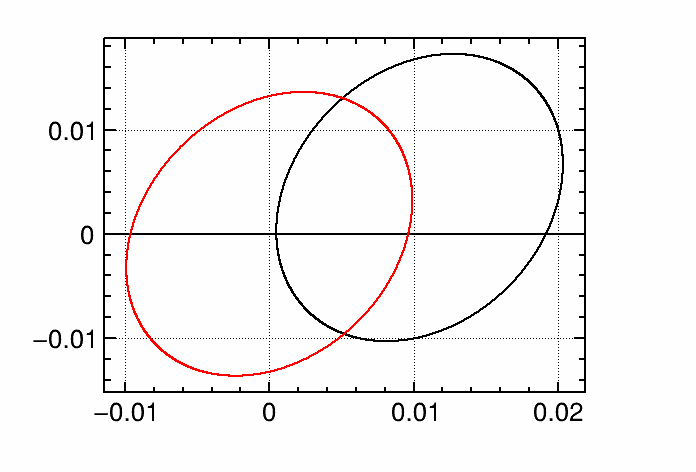

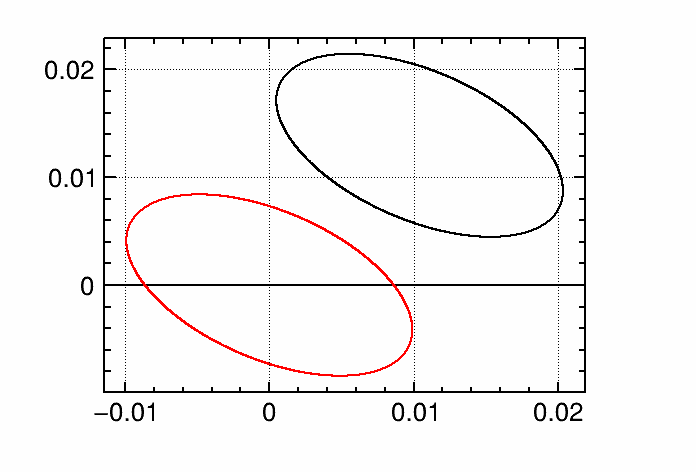

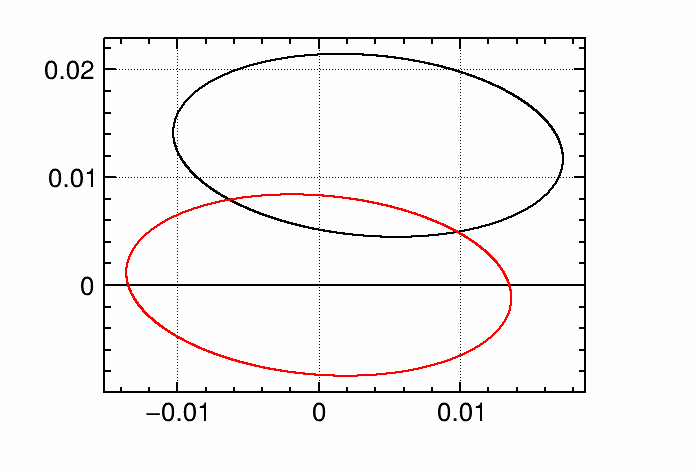

In [47]:
%jsroot off
c_OO_e = {}

for oo_1, oo_2 in combinations(OOs, 2):
    c_OO_e[f"O_{oo_1}O_{oo_2}"] = ROOT.TCanvas()
    # OO_ellipse[f"O_{oo_1}O_{oo_2}_mc"].Draw("al")
    # OO_ellipse[f"O_{oo_1}O_{oo_2}"].Draw("same l")
    OO_ellipses[f"O_{oo_1}O_{oo_2}"].Draw("al")
    c_OO_e[f"O_{oo_1}O_{oo_2}"].SetGrid()
    c_OO_e[f"O_{oo_1}O_{oo_2}"].Draw()